In [1]:
import glob
import json

# Initialize an empty dictionary to hold the merged mesh_signatures
merged_mesh_fingerprints = {}

# Get the list of files matching the pattern
file_pattern = r'D:\BEHAVIOR-1K\asset_pipeline\cad\*\*\artifacts\object_list.json'
files = glob.glob(file_pattern)

# Iterate over each file and merge the mesh_signatures dictionaries
for file in files:
  with open(file, 'r') as f:
    data = json.load(f)
    if 'mesh_fingerprints' in data:
      merged_mesh_fingerprints.update(data['mesh_fingerprints'])

# Now merged_mesh_signatures contains the merged dictionary
print(merged_mesh_fingerprints)

{'edcvwr': [10928, 21832, [0.2458227559566072, 1.714550081328131e-05, 3.7887798729518057e-06, 1.714550081328131e-05, 0.24593387843615655, -2.8468068092146246e-05, 3.7887798729518057e-06, -2.8468068092146246e-05, 0.23863589959985126], [4.0936166939842256e-05, -6.259759396698428e-05, 0.010871032448605156]], 'ntedfx': [8578, 17152, [0.19096303695656358, 2.347621670572761e-10, -8.232896143700924e-10, 2.347621670572761e-10, 0.1909630300856944, 7.255080088887753e-08, -8.232896143700924e-10, 7.255080088887753e-08, 0.1983527595580687], [7.365281717852667e-10, -1.0377629644509057e-08, 0.5938139112404497]], 'svozzf': [17302, 34274, [1.6305354928666378, -0.004084031824409126, -0.01641952955125194, -0.004084031824409126, 1.6799117516171163, -0.15142828013461668, -0.01641952955125194, -0.15142828013461668, 0.08417154209718139], [0.019113242086340687, -0.029251739169984137, 0.1918306164237289]], 'xfpdui': [1303, 2550, [0.17842040153082586, 0.0016608162188881225, -0.028474794390308596, 0.001660816218

In [2]:
# Get the moment of inertia for each mesh
import numpy as np
n = len(merged_mesh_fingerprints)
moments_of_inertia = np.stack([np.array(x[2]).reshape(3, 3)[np.triu_indices(3)] for x in merged_mesh_fingerprints.values()])
print(moments_of_inertia.shape)

(9362, 6)


In [3]:
# For each of the 9 elements in the moment of inertia, get the mean and standard deviation
means = np.mean(moments_of_inertia, axis=0)
std_devs = np.std(moments_of_inertia, axis=0)

print(means)
print(std_devs)

[ 1.15065197e+08  3.35605780e+00  8.12729234e-03  1.89485319e+05
 -8.49451551e-01  1.15254681e+08]
[7.21390772e+09 2.04583958e+02 6.61213405e-01 1.83316358e+07
 8.21570463e+01 7.21392799e+09]


In [4]:
# Compute sample covariance
covariance = np.cov(moments_of_inertia, rowvar=False, bias=True)
inv_covariance = np.linalg.inv(covariance)
print(covariance)

[[ 5.20404646e+19  1.36639669e+12 -9.35127751e+05 -2.18031569e+13
  -1.37659519e+11  5.20404428e+19]
 [ 1.36639669e+12  4.18545961e+04 -2.73417436e-02  1.82359416e+08
   2.86941963e+00  1.36657905e+12]
 [-9.35127751e+05 -2.73417436e-02  4.37203167e-01 -1.62704681e+03
  -6.81372939e-03 -9.36841104e+05]
 [-2.18031569e+13  1.82359416e+08 -1.62704681e+03  3.36048871e+14
   1.60957164e+05  3.14245714e+14]
 [-1.37659519e+11  2.86941963e+00 -6.81372939e-03  1.60957164e+05
   6.74978025e+03 -1.37659358e+11]
 [ 5.20404428e+19  1.36657905e+12 -9.36841104e+05  3.14245714e+14
  -1.37659358e+11  5.20407570e+19]]


In [5]:
# Compute mahalanobis distances between every pair of meshes
def pairwise_mahalanobis(V, SI):
    """
    Compute pairwise Mahalanobis distances between vectors in V using inverse covariance matrix SI.
    
    Parameters:
    V: numpy array of shape (n, p) where n is number of vectors and p is dimensionality
    SI: inverse covariance matrix of shape (p, p)
    
    Returns:
    D: numpy array of shape (n, n) containing pairwise Mahalanobis distances
    """
    # Get number of vectors
    n = V.shape[0]
    
    # Compute difference vectors for all pairs
    # Using broadcasting to create a (n, n, p) array
    diff = V[:, np.newaxis, :] - V  # Shape: (n, n, p)
    
    # Compute Mahalanobis distances
    # For each pair, compute diff @ SI @ diff.T
    # Using einsum for efficient computation
    D = np.sqrt(np.einsum('ijk,kl,ijl->ij', diff, SI, diff))
    
    return D

# Compute pairwise Mahalanobis distances
D = pairwise_mahalanobis(moments_of_inertia, inv_covariance)

C:\Users\Cem\AppData\Local\Temp\ipykernel_15640\2032299907.py:23: RuntimeWarning: invalid value encountered in sqrt
  D = np.sqrt(np.einsum('ijk,kl,ijl->ij', diff, SI, diff))


In [6]:
D.shape

(9362, 9362)

In [20]:
different_object_distances = D[~np.eye(D.shape[0],dtype=bool)]
different_object_distances = different_object_distances[~np.isnan(different_object_distances)]

In [22]:
# Describe the distribution of Mahalanobis distances
print(np.median(different_object_distances))
print(np.mean(different_object_distances))
print(np.std(different_object_distances))
print(np.min(different_object_distances))
print(np.max(different_object_distances))
print(np.percentile(different_object_distances, 25))
print(np.percentile(different_object_distances, 50))
print(np.percentile(different_object_distances, 75))

0.006962825695622798
0.175555350492552
3.5949196528246317
0.0
139.48476619330157
0.0023999700441735797
0.006962825695622798
0.019347857295583963


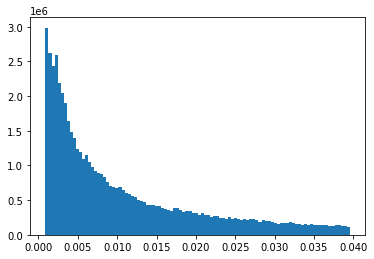

In [23]:
# Plot a histogram of the 10-to-90th percentile of Mahalanobis distances
import matplotlib.pyplot as plt
min_val = np.percentile(different_object_distances, 10)
max_val = np.percentile(different_object_distances, 90)
plt.hist(different_object_distances, bins=100, range=(min_val, max_val))
plt.show()

In [27]:
# Lets look at a particular example, jatssq
bad = (13014, 10432, [0.11338169027658968, -0.0006982750120267411, -0.001630522249463943, -0.0006982750120267411, 0.11209346603884637, -0.0015877659633802192, -0.001630522249463943, -0.0015877659633802192, 0.08144469651441441], [-0.04741873350956649, -0.08014451253401145, -0.233840203355693])
good = merged_mesh_fingerprints["jatssq"]

# Replace both MOIs with the upper triangles
bad_upper = np.array(bad[2]).reshape(3, 3)[np.triu_indices(3)]
good_upper = np.array(good[2]).reshape(3, 3)[np.triu_indices(3)]

print(bad)
print(good)
print(bad_upper - good_upper)

# Compute the Mahalanobis distance between the two
diff = bad_upper - good_upper
mahalanobis = np.sqrt(diff @ inv_covariance @ diff)
print(mahalanobis)M

(13014, 10432, [0.11338169027658968, -0.0006982750120267411, -0.001630522249463943, -0.0006982750120267411, 0.11209346603884637, -0.0015877659633802192, -0.001630522249463943, -0.0015877659633802192, 0.08144469651441441], [-0.04741873350956649, -0.08014451253401145, -0.233840203355693])
[13130, 10435, [0.1133799707843289, -0.0006988471938059997, -0.0016298802804571026, -0.0006988471938059997, 0.112091736785148, -0.0015876373468616352, -0.0016298802804571026, -0.0015876373468616352, 0.08144413629455147], [0.002540507790342872, -0.007821689344871263, -0.35788891535621925]]
[ 1.71949226e-06  5.72181779e-07 -6.41969007e-07  1.72925370e-06
 -1.28616519e-07  5.60219863e-07]
6.305048757433546e-07
